In [49]:
from PyPDF2 import PdfReader
import re
import os
from getpass import getpass

import nltk
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains.conversational_retrieval.base import ConversationalRetrievalChain
from langchain.llms.huggingface_hub import HuggingFaceHub

In [2]:
def extract_text(pdf_docs):
    text=""
    for pdf in pdf_docs:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            text+=page.extract_text()
    return text

In [3]:
# pdf_docs = [r'data\ramayan_summary.pdf', r'data\mahabharat_summary.pdf']
pdf_docs = [r'data\summaries\mahabharat_summary.pdf']


In [4]:
raw_text = extract_text(pdf_docs=pdf_docs)

In [5]:
raw_text

"A Summary of The Mahabharata by Aneeta Sundararaj (heavily augmented by Amy Allison) http://www.homehighlight.org/humanities-and-science/cultures/a-summary-of-the-mahabharata.html  The Mahabharata is an epic that comprises one hundred thousand stanzas of verse divided into eighteen books, or parvas. It is the largest single literary work in existence. Originally composed in the ancient language of Sanskrit sometime between 400 BC and 400 AD, it is set in a legendary era thought to correspond to the period of Indian culture and history in approximately the tenth century BC.   The original “author” was Vyasa who tried to tell about the Great War between the Pandavas and the Kauravas - cousins who claimed to be the rightful rulers of a kingdom.    The background to get to where the epic starts is very confusing (in medias res).  I’ll present the background a bit here just to lay the groundwork.  Background King Santanu married a strange woman he found by the river.  They had many childre

In [6]:
def clean_text(text):
    # Remove unwanted characters
    clean_text = re.sub(r'\n', ' ', text)
    
    # Remove apostrophes
    clean_text = re.sub(r"'", '', clean_text)
    
    # Normalize whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text)
    
    return clean_text

In [7]:
text = clean_text(raw_text)

In [8]:
text

'A Summary of The Mahabharata by Aneeta Sundararaj (heavily augmented by Amy Allison) http://www.homehighlight.org/humanities-and-science/cultures/a-summary-of-the-mahabharata.html The Mahabharata is an epic that comprises one hundred thousand stanzas of verse divided into eighteen books, or parvas. It is the largest single literary work in existence. Originally composed in the ancient language of Sanskrit sometime between 400 BC and 400 AD, it is set in a legendary era thought to correspond to the period of Indian culture and history in approximately the tenth century BC. The original “author” was Vyasa who tried to tell about the Great War between the Pandavas and the Kauravas - cousins who claimed to be the rightful rulers of a kingdom. The background to get to where the epic starts is very confusing (in medias res). I’ll present the background a bit here just to lay the groundwork. Background King Santanu married a strange woman he found by the river. They had many children and she

In [9]:
def get_most_frequent_words(text, num_words=30, common_words=None):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    if common_words is not None:
        stop_words.update(common_words)
        
    all_words = ''.join(text).split()
    filtered_words = [word for word in all_words if word not in stop_words]
    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(num_words)
    return most_common_words

In [10]:
most_freq_words = get_most_frequent_words(text=text)

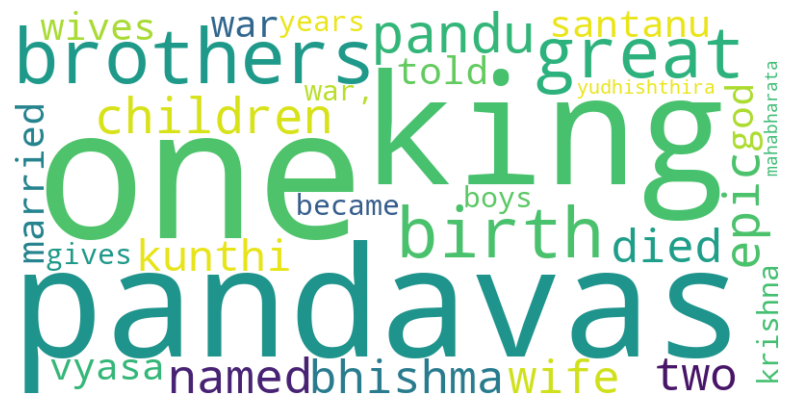

In [11]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_freq_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
def chunking(text):
    # text_splitter = CharacterTextSplitter(separator='\n',chunk_size=1200,chunk_overlap=400,length_function=len)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200,chunk_overlap=400,length_function=len)
    chunks = text_splitter.split_text(text)
    return chunks

In [13]:
chunks = chunking(raw_text)

In [14]:
print(len(chunks), chunks[1], chunks[2], sep='\n'+'-'*100+'\n')

12
----------------------------------------------------------------------------------------------------
is very confusing (in medias res).  I’ll present the background a bit here just to lay the groundwork.  Background King Santanu married a strange woman he found by the river.  They had many children and she drowned all of them (I told you she was strange).  The king stopped her from downing the last child (a boy).  She then said she was a goddess and that this child was a god but had to remain on earth as punishment for stealing a sacred cow in a past life.  The child was named Devavratha, but to confuse you he is called Bhishma (one of firm vow).  The goddess went back to wherever it is that goddesses go, and the king continued ruling.  One day he fell in love with a woman who ran a ferry; her name was Satyavathi.  King Santanu asked her father if he could marry her, and he said yes, but only if Satyavathi’s children inherit, leaving poor Bhishma out in the cold.  Bhishma was actual

In [15]:
def embeddings(chunks):
    embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    faiss = FAISS.from_texts(texts=chunks, embedding=embedding_model)
    return faiss

In [16]:
vector_store = embeddings(chunks)

In [17]:
relevant_context = vector_store.similarity_search_with_relevance_scores(query="Who was Yudhishthira's actual father", k=3)

In [18]:
for context in relevant_context:
    print(f"Similarity score: {context[1]}")
    print(context[0].page_content)
    print("-"*60)

Similarity score: 0.3526936119979226
in a forest fire. Kunti, the mother of the Pandavas was with them too. Krishna departed from this earth thirty-six years after the Great War. When they learned of this, the Pandavas believed it was time for them to leave this world too and they embarked upon the 'Great Journey,' which involved walking north toward the polar mountain that is toward the heavenly worlds, until one's body dropped dead. One by one, beginning with Draupadi, the Pandavas died along the way until Yudhishthira was left alone with a dog that had accompanied him from the start. Yudhishthira made it to the gates of heaven and there refused the order to drive the dog back, at which point the dog was revealed to be an incarnate form of the God Dharma (the God who was Yudhishthira's actual, physical father), who was there to test Yudhishthira's virtue. Once in heaven Yudhishthira faced one final test of his virtue: He saw only the Dhartarashtra Clan in heaven, and he was told that

In [19]:
HUGGINGFACEHUB_API_TOKEN = getpass()

 ········


In [20]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [63]:
# template = """You are epicchat, a chatbot created by rachit. You are trained of the english translations of Ramayana and Mahabharata. Give the following conversation and the input question I want you to answer the question to the best of your ability with the relevant knowledge you are trained on. If you do not have an answer respond honestly your lack of knowledge.
# Histrot:\n{{chat_history}}\nInput Question:\n{{input_question}}
# """

# prompt = PromptTemplate(input_variables=['chat_history', 'input_question'], template=template)
def get_conversation_chain(vector_store):
    repo_id="google/gemma-1.1-2b-it"
    llm = HuggingFaceHub(repo_id=repo_id, huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,  model_kwargs={'temperature':0.5, 'max_length':128})
    memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
    retriever = vector_store.as_retriever(search_type='mmr', search_kwargs={'k': 2, 'lambda_mult': 0.75})
    conv_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=retriever,
        memory=memory,
    )
    return conv_chain

In [64]:
conversation_chain = get_conversation_chain(vector_store)

In [65]:
query = "Who was Yudhishthira's actual father?"
# query = "Who was Bharata's mother and what did she resents?"
response = conversation_chain({'question':query})

In [67]:
response

{'question': "Who was Yudhishthira's actual father?",
 'chat_history': [HumanMessage(content="Who was Yudhishthira's actual father?"),
  AIMessage(content="Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nin a forest fire. Kunti, the mother of the Pandavas was with them too. Krishna departed from this earth thirty-six years after the Great War. When they learned of this, the Pandavas believed it was time for them to leave this world too and they embarked upon the 'Great Journey,' which involved walking north toward the polar mountain that is toward the heavenly worlds, until one's body dropped dead. One by one, beginning with Draupadi, the Pandavas died along the way until Yudhishthira was left alone with a dog that had accompanied him from the start. Yudhishthira made it to the gates of heaven and there refused the order to drive the dog back, at which point the dog was

In [81]:
def parse_ans(response, chat_history_index, answer_pattern = r'Helpful Answer: (.+)'):
    answer = None
    response_str = response['chat_history'][chat_history_index].content
    match = re.search(answer_pattern, response_str)
    print(match, match.group(), sep='\n')
    if match:
        answer = match.group(1)
        
    return answer

In [82]:
ans = parse_ans(response, chat_history_index=1)
if ans is not None:
    print(ans)
else:
    print("could not find an answer")

<re.Match object; span=(2216, 2295), match="Helpful Answer: Dharma, the God who was Yudhishth>
Helpful Answer: Dharma, the God who was Yudhishthira's actual, physical father.
Dharma, the God who was Yudhishthira's actual, physical father.


In [70]:
query = "what was the actual previous question asked to you?"
response = conversation_chain({'question':query})

In [83]:
ans = parse_ans(response, chat_history_index=3)
if ans is not None:
    print(ans)
else:
    print("could not find an answer")

<re.Match object; span=(5004, 5083), match="Helpful Answer: Dharma, the God who was Yudhishth>
Helpful Answer: Dharma, the God who was Yudhishthira's actual, physical father.
Dharma, the God who was Yudhishthira's actual, physical father.


In [71]:
response

{'question': 'what was the actual previous question asked to you?',
 'chat_history': [HumanMessage(content="Who was Yudhishthira's actual father?"),
  AIMessage(content="Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nin a forest fire. Kunti, the mother of the Pandavas was with them too. Krishna departed from this earth thirty-six years after the Great War. When they learned of this, the Pandavas believed it was time for them to leave this world too and they embarked upon the 'Great Journey,' which involved walking north toward the polar mountain that is toward the heavenly worlds, until one's body dropped dead. One by one, beginning with Draupadi, the Pandavas died along the way until Yudhishthira was left alone with a dog that had accompanied him from the start. Yudhishthira made it to the gates of heaven and there refused the order to drive the dog back, at which poi

In [73]:
response['chat_history'][3].pretty_print()

================================== Ai Message ==================================

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

in a forest fire. Kunti, the mother of the Pandavas was with them too. Krishna departed from this earth thirty-six years after the Great War. When they learned of this, the Pandavas believed it was time for them to leave this world too and they embarked upon the 'Great Journey,' which involved walking north toward the polar mountain that is toward the heavenly worlds, until one's body dropped dead. One by one, beginning with Draupadi, the Pandavas died along the way until Yudhishthira was left alone with a dog that had accompanied him from the start. Yudhishthira made it to the gates of heaven and there refused the order to drive the dog back, at which point the dog was revealed to be an incarnate form of the God Dharma (the God who was Yudhish

In [74]:
query = "who werre the survivors of the great war?"
response = conversation_chain({'question':query})

In [84]:
ans = parse_ans(response, chat_history_index=5)
if ans is not None:
    print(ans)
else:
    print("could not find an answer")

<re.Match object; span=(5004, 5083), match="Helpful Answer: Dharma, the God who was Yudhishth>
Helpful Answer: Dharma, the God who was Yudhishthira's actual, physical father.
Dharma, the God who was Yudhishthira's actual, physical father.


In [98]:
response['chat_history'][-1].content

"Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nin a forest fire. Kunti, the mother of the Pandavas was with them too. Krishna departed from this earth thirty-six years after the Great War. When they learned of this, the Pandavas believed it was time for them to leave this world too and they embarked upon the 'Great Journey,' which involved walking north toward the polar mountain that is toward the heavenly worlds, until one's body dropped dead. One by one, beginning with Draupadi, the Pandavas died along the way until Yudhishthira was left alone with a dog that had accompanied him from the start. Yudhishthira made it to the gates of heaven and there refused the order to drive the dog back, at which point the dog was revealed to be an incarnate form of the God Dharma (the God who was Yudhishthira's actual, physical father), who was there to test Yudhishthira's virtue. 

In [99]:
last_response = response["chat_history"][-1].content

questions = re.findall(r"Question:\s*(.+?)\n", last_response)
helpful_answers = re.findall(r"Helpful Answer:\s*(.+?)\n", last_response)

print("Questions:")
for question in questions:
    print(question)

print("\nHelpful Answers:")
for answer in helpful_answers:
    print(answer)

Questions:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.
Who was Yudhishthira's actual father?
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.
Who was Yudhishthira's actual father?

Helpful Answers:
Dharma, the God who was Yudhishthira's actual, physical father.
Dharma, the God who was Yudhishthira's actual, physical father.
The previous question asked about Yudhishthira's actual father.
